<a href="https://www.kaggle.com/code/mesutssmn/telecom-churn-data-analysis-and-ml?scriptVersionId=170494621" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 55)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df20 = pd.read_csv("/kaggle/input/telecom-churn-datasets/churn-bigml-20.csv")
df80 = pd.read_csv("/kaggle/input/telecom-churn-datasets/churn-bigml-80.csv")
df = pd.concat([df20, df80], ignore_index=True)
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.500,97,31.370,351.600,80,29.890,215.800,90,9.710,8.700,4,2.350,1,False
1,IN,65,415,No,No,0,129.100,137,21.950,228.500,83,19.420,208.800,111,9.400,12.700,6,3.430,4,True
2,NY,161,415,No,No,0,332.900,67,56.590,317.800,97,27.010,160.600,128,7.230,5.400,9,1.460,4,True
3,SC,111,415,No,No,0,110.400,103,18.770,137.300,102,11.670,189.600,105,8.530,7.700,6,2.080,2,False
4,HI,49,510,No,No,0,119.300,117,20.280,215.100,109,18.280,178.700,90,8.040,11.100,1,3.000,1,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [5]:
df.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 3333
Variables: 20
cat_cols: 4
num_cols: 15
cat_but_car: 1
num_but_cat: 2


In [7]:
cat_cols, num_cols, cat_but_car

(['International plan', 'Voice mail plan', 'Area code', 'Churn'],
 ['Account length',
  'Number vmail messages',
  'Total day minutes',
  'Total day calls',
  'Total day charge',
  'Total eve minutes',
  'Total eve calls',
  'Total eve charge',
  'Total night minutes',
  'Total night calls',
  'Total night charge',
  'Total intl minutes',
  'Total intl calls',
  'Total intl charge',
  'Customer service calls'],
 ['State'])

In [8]:
df[['International plan', 'Voice mail plan', 'Area code', 'Churn']]

,International plan,Voice mail plan,Area code,Churn
0,No,No,408,False
1,No,No,415,True
2,No,No,415,True
3,No,No,415,False
4,No,No,510,False
...,...,...,...,...
3328,No,No,415,False
3329,No,Yes,415,False
3330,No,No,415,False
3331,No,No,510,False


In [9]:
df["International plan"] = df["International plan"].replace({"No": 0, "Yes": 1})
df["Voice mail plan"] = df["Voice mail plan"].replace({"No": 0, "Yes": 1})
df["Churn"] = df["Churn"].astype(int)

In [10]:
df = df.drop(["State"], axis=1)

In [11]:
df[['International plan', 'Voice mail plan', 'Area code', 'Churn']]

,International plan,Voice mail plan,Area code,Churn
0,0,0,408,0
1,0,0,415,1
2,0,0,415,1
3,0,0,415,0
4,0,0,510,0
...,...,...,...,...
3328,0,0,415,0
3329,0,1,415,0
3330,0,0,415,0
3331,0,0,510,0


In [12]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,117,408,0,0,0,184.500,97,31.370,351.600,80,29.890,215.800,90,9.710,8.700,4,2.350,1,0
1,65,415,0,0,0,129.100,137,21.950,228.500,83,19.420,208.800,111,9.400,12.700,6,3.430,4,1
2,161,415,0,0,0,332.900,67,56.590,317.800,97,27.010,160.600,128,7.230,5.400,9,1.460,4,1
3,111,415,0,0,0,110.400,103,18.770,137.300,102,11.670,189.600,105,8.530,7.700,6,2.080,2,0
4,49,510,0,0,0,119.300,117,20.280,215.100,109,18.280,178.700,90,8.040,11.100,1,3.000,1,0


In [13]:
df["Area code"].unique()

array([408, 415, 510])

                    International plan  Ratio
International plan                           
0                                 3010 90.309
1                                  323  9.691


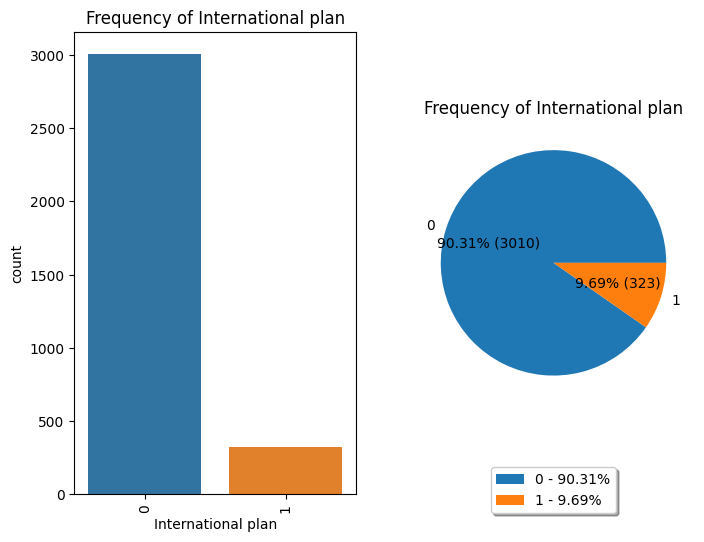

                 Voice mail plan  Ratio
Voice mail plan                        
0                           2411 72.337
1                            922 27.663


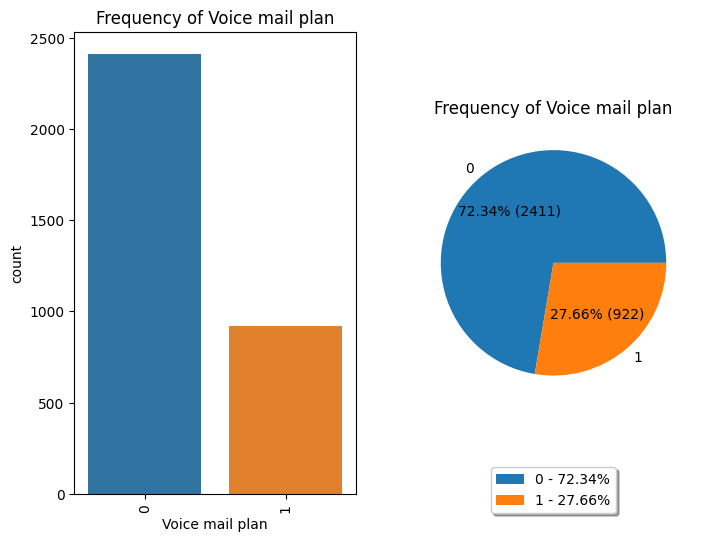

           Area code  Ratio
Area code                  
415             1655 49.655
510              840 25.203
408              838 25.143


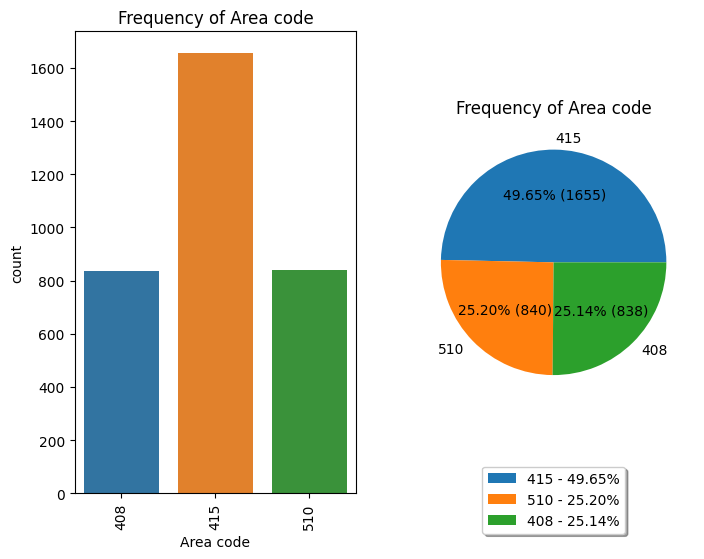

       Churn  Ratio
Churn              
0       2850 85.509
1        483 14.491


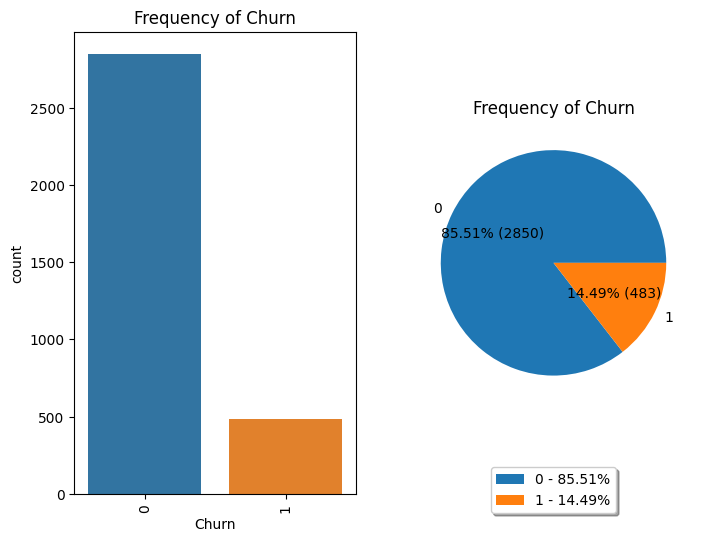

In [14]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(8, 6))
        plt.subplot(1, 2, 1)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.title("Frequency of " + col_name)
        plt.xticks(rotation=90)

        plt.subplot(1, 2, 2)
        values = dataframe[col_name].value_counts()
        plt.pie(x=values, labels=values.index, autopct=lambda p: '{:.2f}% ({:.0f})'.format(p, p/100 * sum(values)))
        plt.title("Frequency of " + col_name)
        plt.legend(labels=['{} - {:.2f}%'.format(index, value/sum(values)*100) for index, value in zip(values.index, values)],
                   loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, True)

count   3333.000
mean     101.065
std       39.822
min        1.000
5%        35.000
10%       50.000
20%       67.000
30%       80.000
40%       91.000
50%      101.000
60%      111.000
70%      122.000
80%      134.000
90%      152.000
95%      167.000
99%      195.000
max      243.000
Name: Account length, dtype: float64


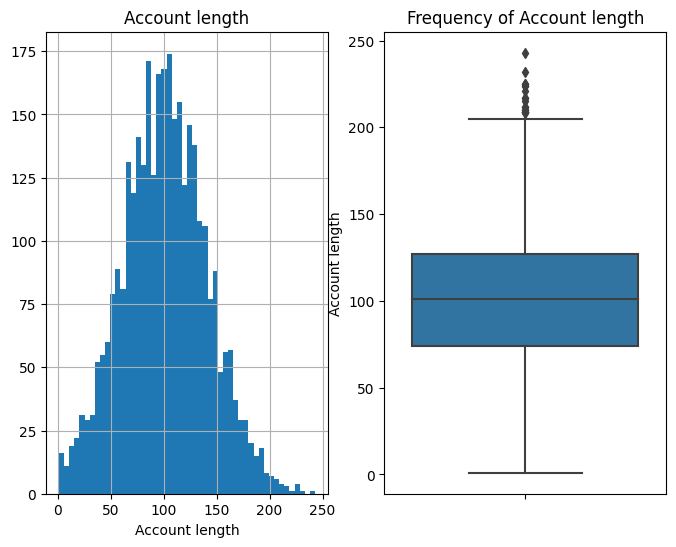

#####################################
count   3333.000
mean       8.099
std       13.688
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%       25.000
90%       32.000
95%       36.000
99%       43.000
max       51.000
Name: Number vmail messages, dtype: float64


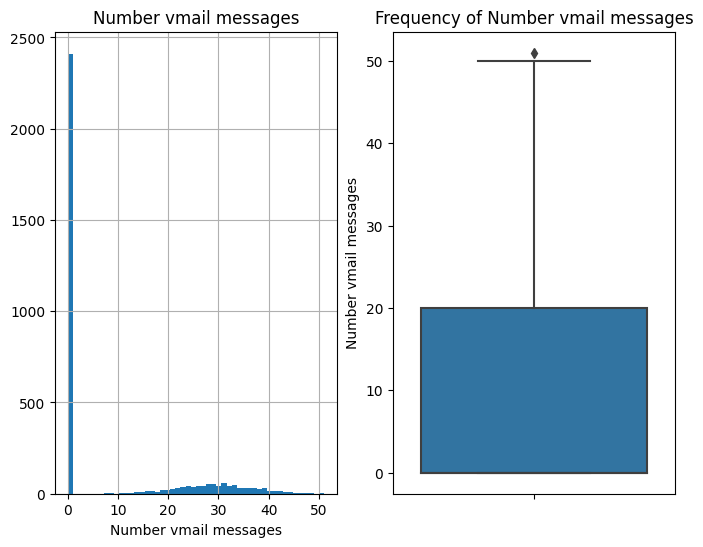

#####################################
count   3333.000
mean     179.775
std       54.467
min        0.000
5%        89.920
10%      110.320
20%      134.740
30%      151.100
40%      165.680
50%      179.400
60%      194.000
70%      208.740
80%      224.760
90%      249.580
95%      270.740
99%      305.168
max      350.800
Name: Total day minutes, dtype: float64


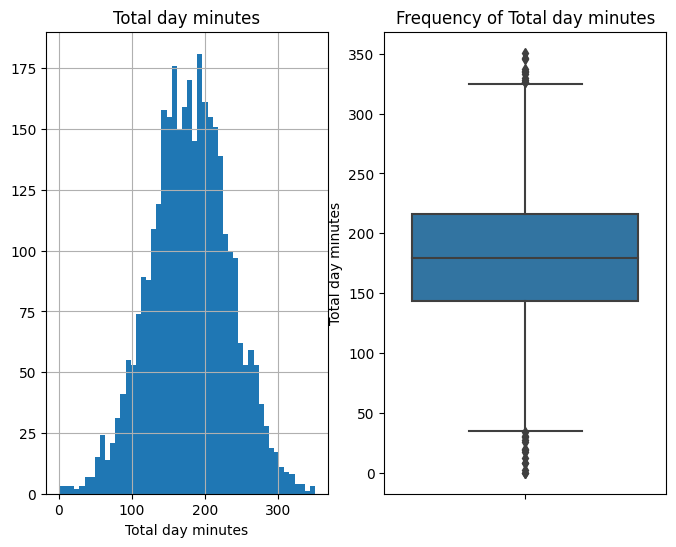

#####################################
count   3333.000
mean     100.436
std       20.069
min        0.000
5%        67.000
10%       74.200
20%       84.000
30%       90.000
40%       96.000
50%      101.000
60%      106.000
70%      111.000
80%      117.000
90%      126.000
95%      133.000
99%      146.000
max      165.000
Name: Total day calls, dtype: float64


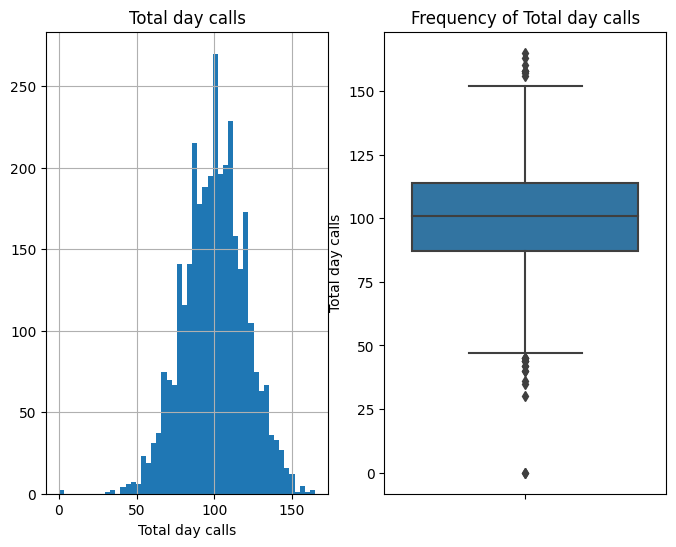

#####################################
count   3333.000
mean      30.562
std        9.259
min        0.000
5%        15.288
10%       18.754
20%       22.908
30%       25.690
40%       28.166
50%       30.500
60%       32.980
70%       35.488
80%       38.212
90%       42.428
95%       46.028
99%       51.877
max       59.640
Name: Total day charge, dtype: float64


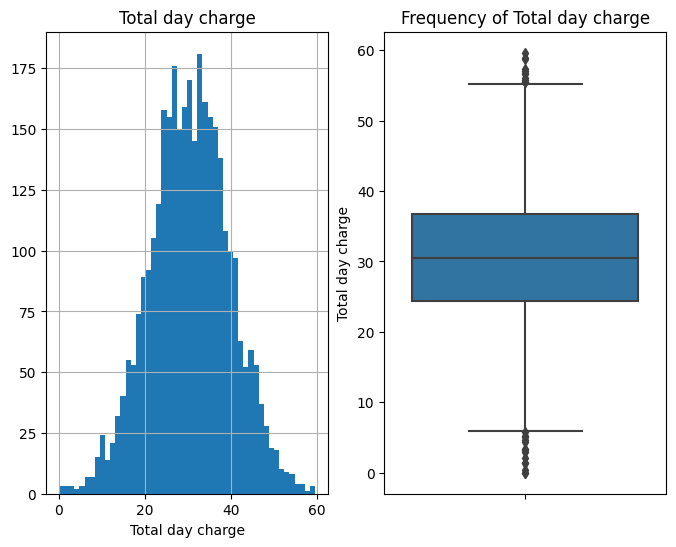

#####################################
count   3333.000
mean     200.980
std       50.714
min        0.000
5%       118.800
10%      136.720
20%      158.940
30%      173.300
40%      188.000
50%      201.400
60%      213.440
70%      226.740
80%      244.400
90%      265.800
95%      284.300
99%      318.936
max      363.700
Name: Total eve minutes, dtype: float64


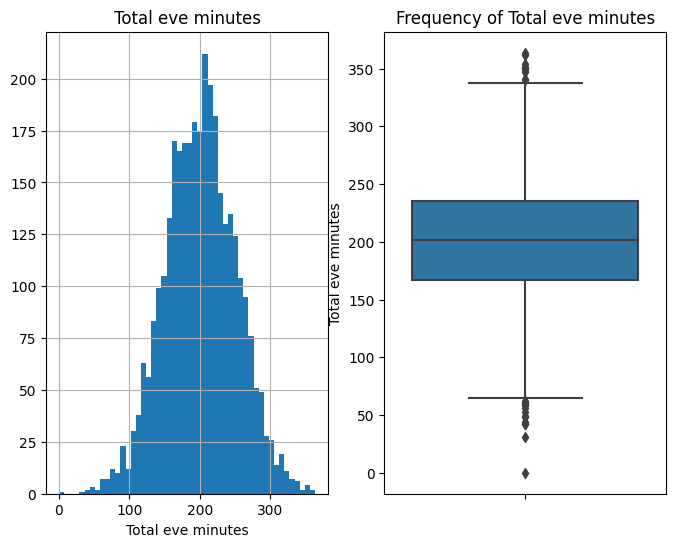

#####################################
count   3333.000
mean     100.114
std       19.923
min        0.000
5%        67.000
10%       75.000
20%       84.000
30%       90.000
40%       95.000
50%      100.000
60%      105.000
70%      111.000
80%      117.000
90%      125.000
95%      133.000
99%      147.000
max      170.000
Name: Total eve calls, dtype: float64


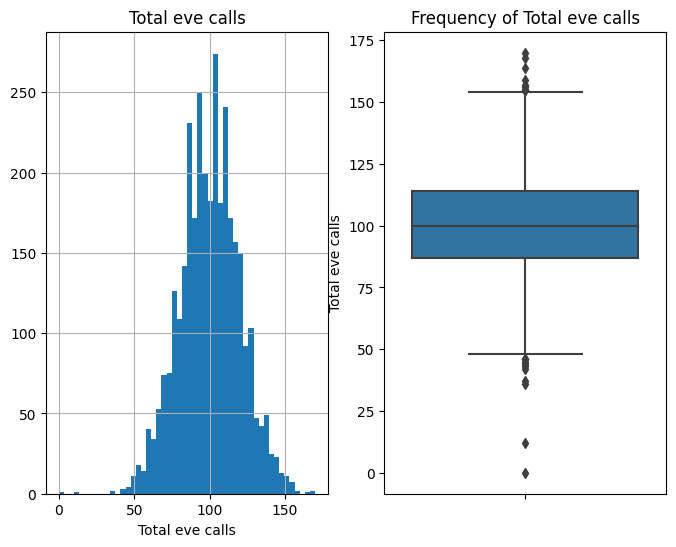

#####################################
count   3333.000
mean      17.084
std        4.311
min        0.000
5%        10.100
10%       11.622
20%       13.514
30%       14.730
40%       15.980
50%       17.120
60%       18.144
70%       19.274
80%       20.770
90%       22.590
95%       24.170
99%       27.114
max       30.910
Name: Total eve charge, dtype: float64


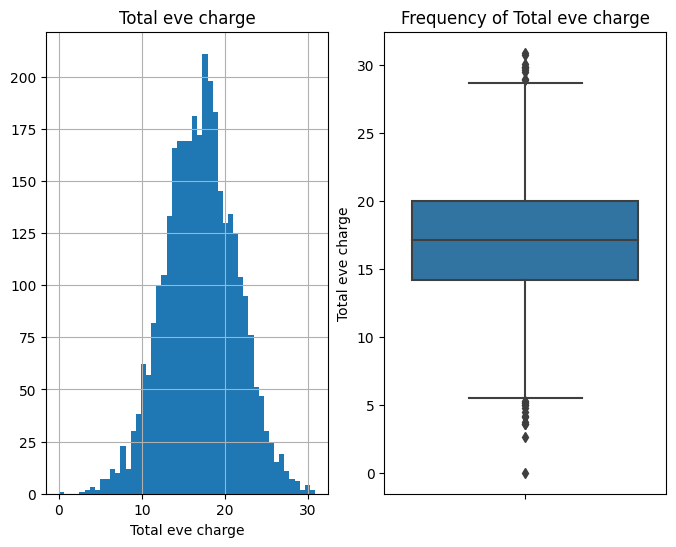

#####################################
count   3333.000
mean     200.872
std       50.574
min       23.200
5%       118.180
10%      136.340
20%      158.600
30%      174.000
40%      188.200
50%      201.200
60%      214.000
70%      227.540
80%      243.900
90%      264.200
95%      282.840
99%      317.448
max      395.000
Name: Total night minutes, dtype: float64


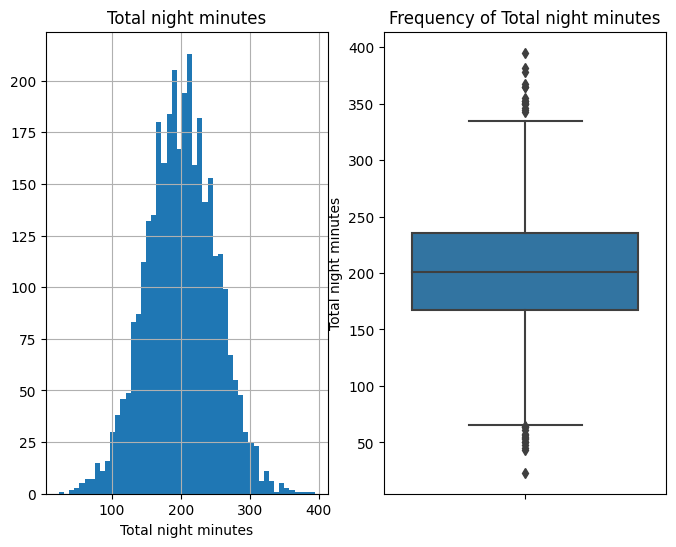

#####################################
count   3333.000
mean     100.108
std       19.569
min       33.000
5%        68.000
10%       75.000
20%       83.000
30%       90.000
40%       95.000
50%      100.000
60%      105.000
70%      110.000
80%      117.000
90%      125.000
95%      132.000
99%      146.680
max      175.000
Name: Total night calls, dtype: float64


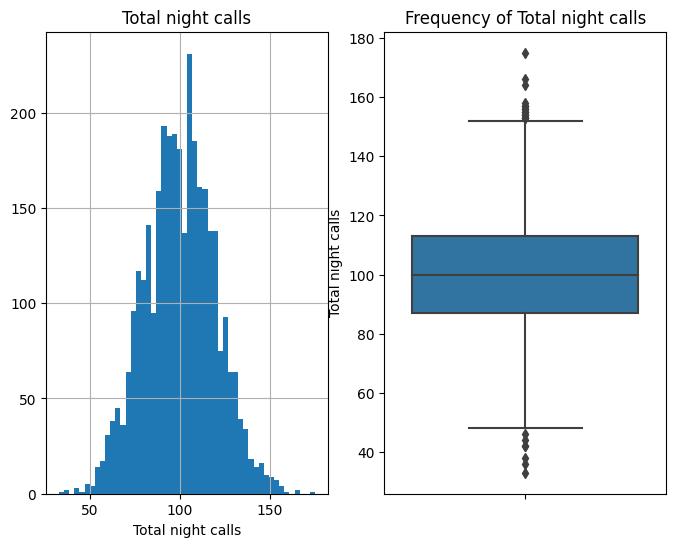

#####################################
count   3333.000
mean       9.039
std        2.276
min        1.040
5%         5.316
10%        6.132
20%        7.140
30%        7.830
40%        8.470
50%        9.050
60%        9.630
70%       10.240
80%       10.980
90%       11.890
95%       12.730
99%       14.284
max       17.770
Name: Total night charge, dtype: float64


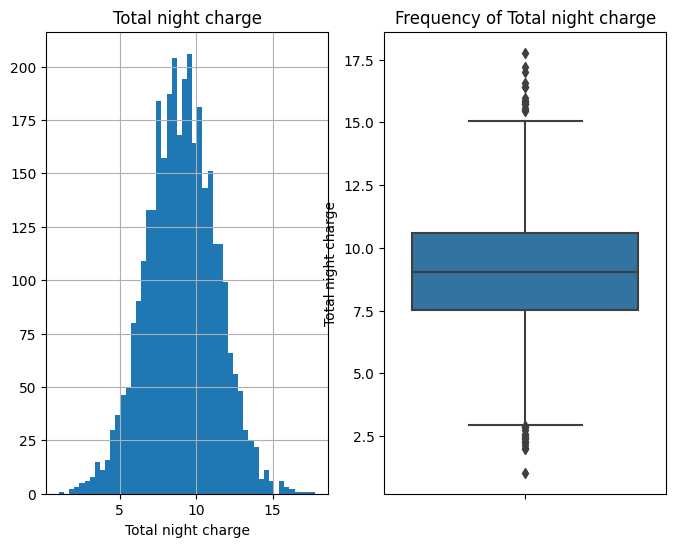

#####################################
count   3333.000
mean      10.237
std        2.792
min        0.000
5%         5.700
10%        6.700
20%        8.000
30%        8.900
40%        9.700
50%       10.300
60%       11.000
70%       11.700
80%       12.500
90%       13.700
95%       14.700
99%       16.668
max       20.000
Name: Total intl minutes, dtype: float64


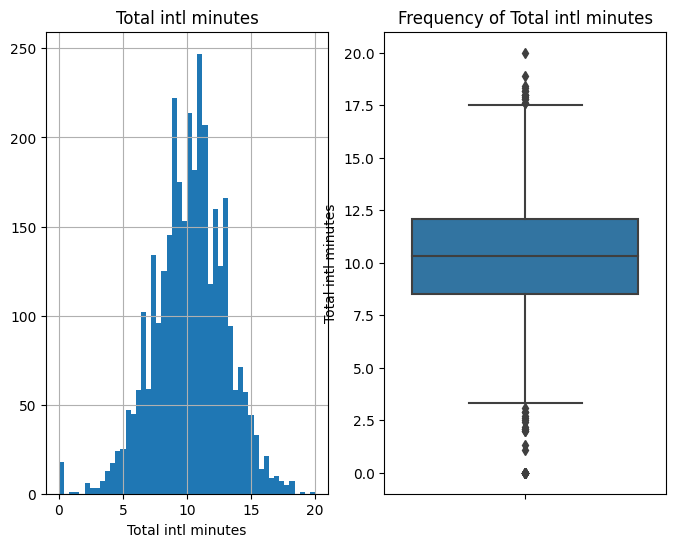

#####################################
count   3333.000
mean       4.479
std        2.461
min        0.000
5%         1.000
10%        2.000
20%        2.400
30%        3.000
40%        3.000
50%        4.000
60%        5.000
70%        5.000
80%        6.000
90%        8.000
95%        9.000
99%       13.000
max       20.000
Name: Total intl calls, dtype: float64


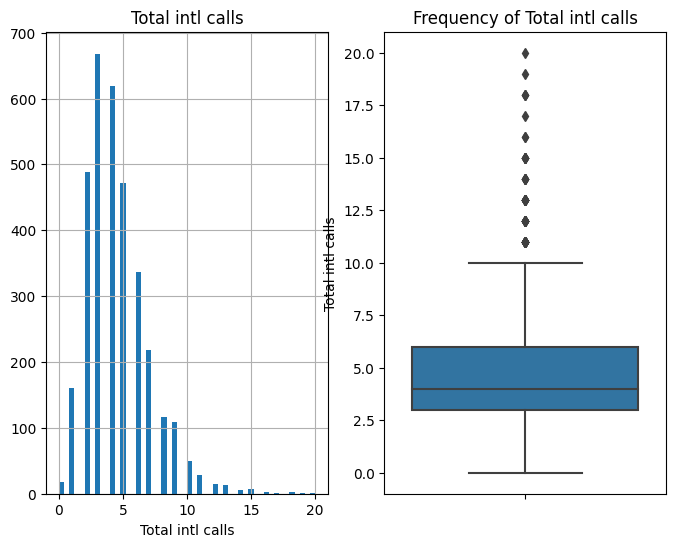

#####################################
count   3333.000
mean       2.765
std        0.754
min        0.000
5%         1.540
10%        1.810
20%        2.160
30%        2.400
40%        2.620
50%        2.780
60%        2.970
70%        3.160
80%        3.380
90%        3.700
95%        3.970
99%        4.500
max        5.400
Name: Total intl charge, dtype: float64


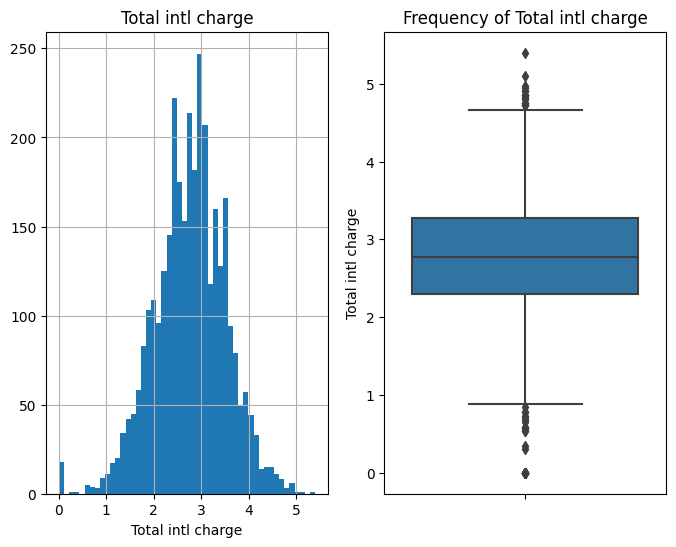

#####################################
count   3333.000
mean       1.563
std        1.315
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        1.000
40%        1.000
50%        1.000
60%        2.000
70%        2.000
80%        3.000
90%        3.000
95%        4.000
99%        6.000
max        9.000
Name: Customer service calls, dtype: float64


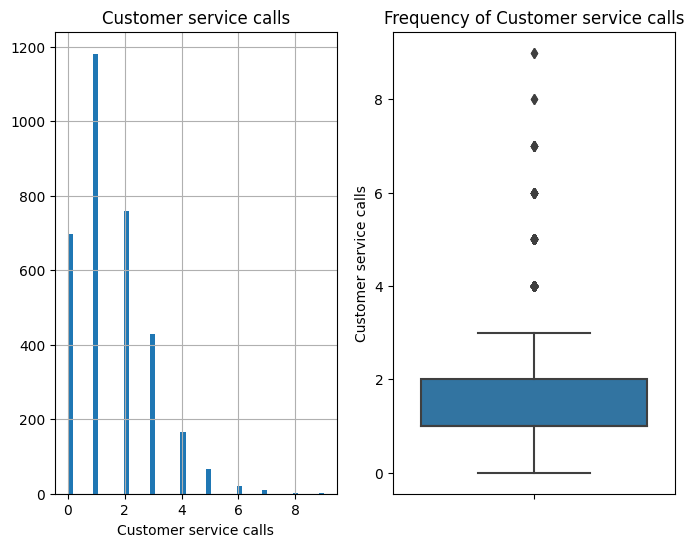

#####################################


In [15]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
            fig, axs = plt.subplots(1, 2, figsize=(8, 6))
            plt.subplot(1, 2, 1)
            dataframe[numerical_col].hist(bins=50)
            plt.xlabel(numerical_col)
            plt.title(numerical_col)

            plt.subplot(1, 2, 2)
            sns.boxplot(y=numerical_col, data=dataframe)
            plt.title("Frequency of " + numerical_col)
            plt.xticks(rotation=90)

            plt.show(block=True)      

    print("#####################################")

for col in num_cols:
    num_summary(df, col, plot=True)

In [16]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Churn", col)

       Account length
Churn                
0             100.794
1             102.665


       Number vmail messages
Churn                       
0                      8.605
1                      5.116


       Total day minutes
Churn                   
0                175.176
1                206.914


       Total day calls
Churn                 
0              100.283
1              101.335


       Total day charge
Churn                  
0                29.780
1                35.176


       Total eve minutes
Churn                   
0                199.043
1                212.410


       Total eve calls
Churn                 
0              100.039
1              100.561


       Total eve charge
Churn                  
0                16.919
1                18.055


       Total night minutes
Churn                     
0                  200.133
1                  205.232


       Total night calls
Churn                   
0                100.058
1                10

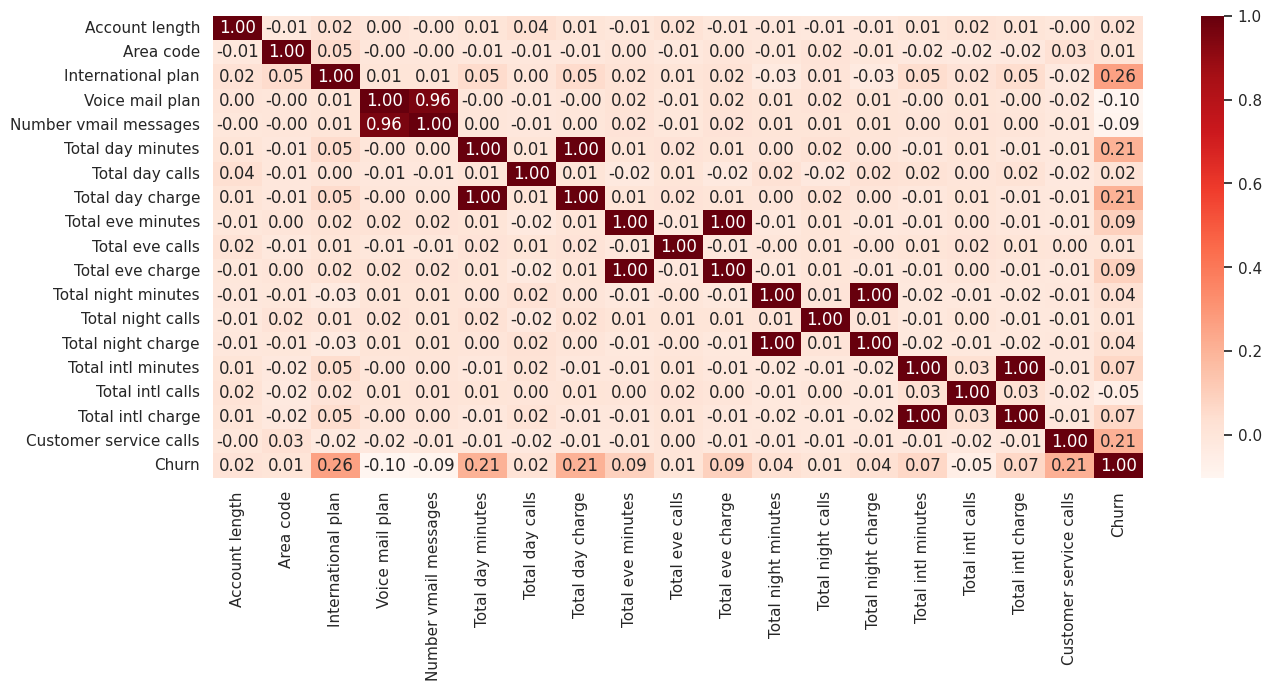

In [17]:
corr = df.corr()
sns.set(rc={'figure.figsize': (15, 6)})
sns.heatmap(corr, cmap="Reds", annot=True, fmt=".2f")
plt.show()

In [18]:
y = df["Churn"]
X = df.drop("Churn", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [19]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.94
Recall: 0.893
Precision: 0.71
F1: 0.79
Auc: 0.92


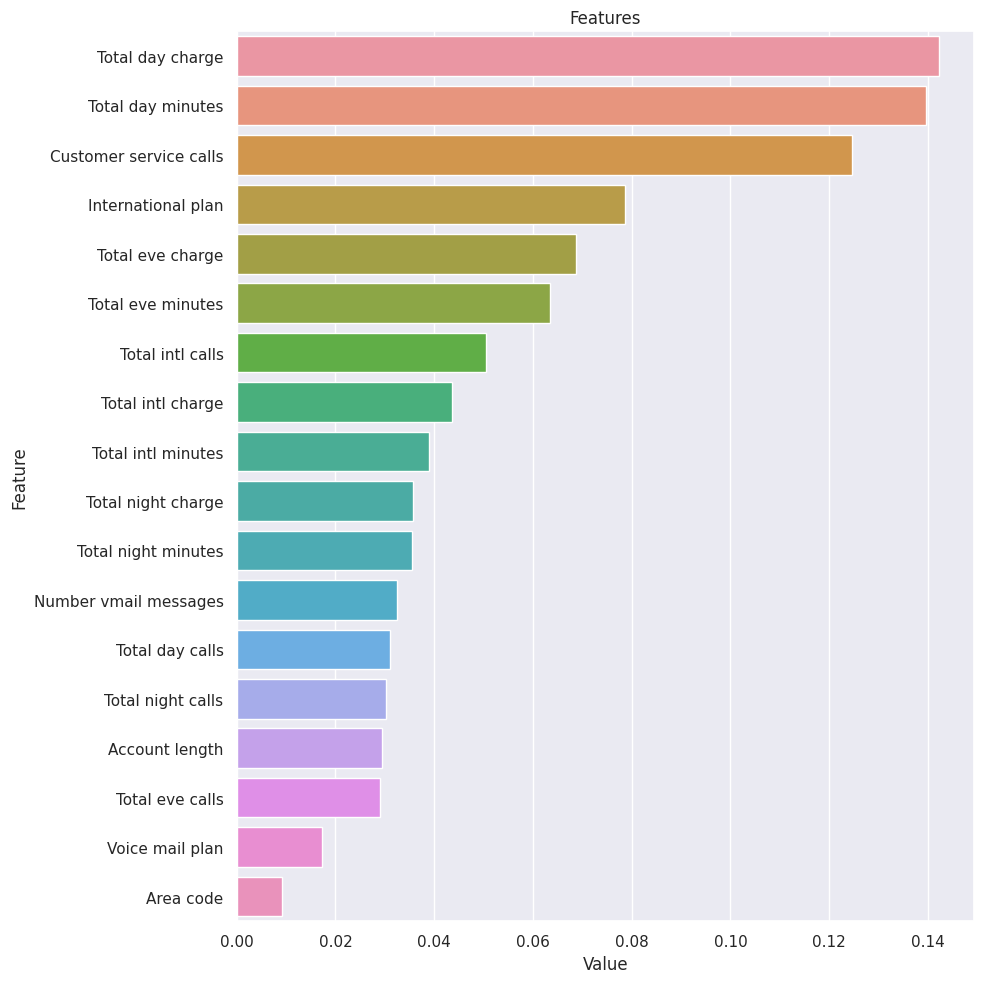

In [20]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

In [21]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [22]:
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

Account length False
Area code False
International plan False
Voice mail plan False
Number vmail messages False
Total day minutes False
Total day calls False
Total day charge False
Total eve minutes False
Total eve calls False
Total eve charge False
Total night minutes False
Total night calls False
Total night charge False
Total intl minutes False
Total intl calls False
Total intl charge False
Customer service calls False
Churn False


In [23]:
for col in df.columns:
    print(col, check_outlier(df, col))

Account length False
Area code False
International plan False
Voice mail plan False
Number vmail messages False
Total day minutes False
Total day calls False
Total day charge False
Total eve minutes False
Total eve calls False
Total eve charge False
Total night minutes False
Total night calls False
Total night charge False
Total intl minutes False
Total intl calls False
Total intl charge False
Customer service calls False
Churn False


In [24]:
df.columns = [col.upper() for col in df.columns]

df.head()

,ACCOUNT LENGTH,AREA CODE,INTERNATIONAL PLAN,VOICE MAIL PLAN,NUMBER VMAIL MESSAGES,TOTAL DAY MINUTES,TOTAL DAY CALLS,TOTAL DAY CHARGE,TOTAL EVE MINUTES,TOTAL EVE CALLS,TOTAL EVE CHARGE,TOTAL NIGHT MINUTES,TOTAL NIGHT CALLS,TOTAL NIGHT CHARGE,TOTAL INTL MINUTES,TOTAL INTL CALLS,TOTAL INTL CHARGE,CUSTOMER SERVICE CALLS,CHURN
0,117,408,0,0,0,184.500,97,31.370,351.600,80,29.890,215.800,90,9.710,8.700,4,2.350,1,0
1,65,415,0,0,0,129.100,137,21.950,228.500,83,19.420,208.800,111,9.400,12.700,6,3.430,4,1
2,161,415,0,0,0,332.900,67,56.590,317.800,97,27.010,160.600,128,7.230,5.400,9,1.460,4,1
3,111,415,0,0,0,110.400,103,18.770,137.300,102,11.670,189.600,105,8.530,7.700,6,2.080,2,0
4,49,510,0,0,0,119.300,117,20.280,215.100,109,18.280,178.700,90,8.040,11.100,1,3.000,1,0


In [25]:
df['TOTALMINUTES'] = df['TOTAL DAY MINUTES'] + df['TOTAL EVE MINUTES'] + df['TOTAL NIGHT MINUTES']

df['TOTALCHARGES'] = df['TOTAL DAY CHARGE'] + df['TOTAL EVE CHARGE'] + df['TOTAL NIGHT CHARGE']

df['TOTALCALLS'] = df['TOTAL DAY CALLS'] + df['TOTAL EVE CALLS'] + df['TOTAL NIGHT CALLS']

df['AVGDAYCALLDURATION'] = df['TOTAL DAY MINUTES'] / df['TOTAL DAY CALLS']
df['AVGEVECALLDURATION'] = df['TOTAL EVE MINUTES'] / df['TOTAL EVE CALLS']
df['AVGNIGHTCALLDURATION'] = df['TOTAL NIGHT MINUTES'] / df['TOTAL NIGHT CALLS']

df['AVGINTLCHARGEPERMINUTE'] = df['TOTAL INTL CHARGE'] / df['TOTAL INTL MINUTES']

df['AVGDAYCHARGEPERCALL'] = df['TOTAL DAY CHARGE'] / df['TOTAL DAY CALLS']
df['AVGEVECHARGEPERCALL'] = df['TOTAL EVE CHARGE'] / df['TOTAL EVE CALLS']
df['AVGNIGHTCHARGEPERCALL'] = df['TOTAL NIGHT CHARGE'] / df['TOTAL NIGHT CALLS']

df['AVGINTLCHARGEPERCALL'] = df['TOTAL INTL CHARGE'] / df['TOTAL INTL CALLS']

df['AVGVMAILCHARGEPERMESSAGE'] = df['TOTAL DAY CHARGE'] / df['NUMBER VMAIL MESSAGES']

df['AVGSERVICECALLCHARGE'] = df['TOTAL DAY CHARGE'] / df['CUSTOMER SERVICE CALLS']

In [26]:
df = pd.get_dummies(df, columns=["AREA CODE"], drop_first=True)
df[["AREA CODE_415","AREA CODE_510"]] = df[["AREA CODE_415","AREA CODE_510"]].astype(int)

In [27]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 3333
Variables: 33
cat_cols: 5
num_cols: 28
cat_but_car: 0
num_but_cat: 5


In [28]:
df.head()

,ACCOUNT LENGTH,INTERNATIONAL PLAN,VOICE MAIL PLAN,NUMBER VMAIL MESSAGES,TOTAL DAY MINUTES,TOTAL DAY CALLS,TOTAL DAY CHARGE,TOTAL EVE MINUTES,TOTAL EVE CALLS,TOTAL EVE CHARGE,TOTAL NIGHT MINUTES,TOTAL NIGHT CALLS,TOTAL NIGHT CHARGE,TOTAL INTL MINUTES,TOTAL INTL CALLS,TOTAL INTL CHARGE,CUSTOMER SERVICE CALLS,CHURN,TOTALMINUTES,TOTALCHARGES,TOTALCALLS,AVGDAYCALLDURATION,AVGEVECALLDURATION,AVGNIGHTCALLDURATION,AVGINTLCHARGEPERMINUTE,AVGDAYCHARGEPERCALL,AVGEVECHARGEPERCALL,AVGNIGHTCHARGEPERCALL,AVGINTLCHARGEPERCALL,AVGVMAILCHARGEPERMESSAGE,AVGSERVICECALLCHARGE,AREA CODE_415,AREA CODE_510
0,117,0,0,0,184.500,97,31.370,351.600,80,29.890,215.800,90,9.710,8.700,4,2.350,1,0,751.900,70.970,267,1.902,4.395,2.398,0.270,0.323,0.374,0.108,0.588,inf,31.370,0,0
1,65,0,0,0,129.100,137,21.950,228.500,83,19.420,208.800,111,9.400,12.700,6,3.430,4,1,566.400,50.770,331,0.942,2.753,1.881,0.270,0.160,0.234,0.085,0.572,inf,5.487,1,0
2,161,0,0,0,332.900,67,56.590,317.800,97,27.010,160.600,128,7.230,5.400,9,1.460,4,1,811.300,90.830,292,4.969,3.276,1.255,0.270,0.845,0.278,0.056,0.162,inf,14.148,1,0
3,111,0,0,0,110.400,103,18.770,137.300,102,11.670,189.600,105,8.530,7.700,6,2.080,2,0,437.300,38.970,310,1.072,1.346,1.806,0.270,0.182,0.114,0.081,0.347,inf,9.385,1,0
4,49,0,0,0,119.300,117,20.280,215.100,109,18.280,178.700,90,8.040,11.100,1,3.000,1,0,513.100,46.600,316,1.020,1.973,1.986,0.270,0.173,0.168,0.089,3.000,inf,20.280,0,1


In [29]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

df.fillna(df.mean(), inplace=True)

In [30]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

,ACCOUNT LENGTH,INTERNATIONAL PLAN,VOICE MAIL PLAN,NUMBER VMAIL MESSAGES,TOTAL DAY MINUTES,TOTAL DAY CALLS,TOTAL DAY CHARGE,TOTAL EVE MINUTES,TOTAL EVE CALLS,TOTAL EVE CHARGE,TOTAL NIGHT MINUTES,TOTAL NIGHT CALLS,TOTAL NIGHT CHARGE,TOTAL INTL MINUTES,TOTAL INTL CALLS,TOTAL INTL CHARGE,CUSTOMER SERVICE CALLS,CHURN,TOTALMINUTES,TOTALCHARGES,TOTALCALLS,AVGDAYCALLDURATION,AVGEVECALLDURATION,AVGNIGHTCALLDURATION,AVGINTLCHARGEPERMINUTE,AVGDAYCHARGEPERCALL,AVGEVECHARGEPERCALL,AVGNIGHTCHARGEPERCALL,AVGINTLCHARGEPERCALL,AVGVMAILCHARGEPERMESSAGE,AVGSERVICECALLCHARGE,AREA CODE_415,AREA CODE_510
0,0.400,0,0,-0.592,0.087,-0.171,0.087,2.970,-1.010,2.971,0.295,-0.517,0.295,-0.551,-0.195,-0.550,-0.428,0,1.893,1.362,-0.981,0.040,2.955,0.431,0.178,0.041,2.956,0.431,-0.416,0.000,1.064,0,0
1,-0.906,0,0,-0.592,-0.931,1.822,-0.930,0.543,-0.859,0.542,0.157,0.557,0.159,0.882,0.618,0.883,1.853,1,-0.169,-0.564,0.884,-1.272,0.837,-0.297,0.068,-1.272,0.837,-0.296,-0.442,0.000,-1.442,1,0
2,1.505,0,0,-0.592,2.812,-1.666,2.811,2.304,-0.156,2.303,-0.796,1.426,-0.795,-1.733,1.837,-1.731,1.853,1,2.553,3.256,-0.252,4.234,1.512,-1.180,0.957,4.234,1.512,-1.179,-1.114,0.000,-0.604,1,0
3,0.250,0,0,-0.592,-1.274,0.128,-1.274,-1.256,0.095,-1.256,-0.223,0.250,-0.224,-0.909,0.618,-0.908,0.332,0,-1.604,-1.689,0.272,-1.095,-0.977,-0.403,0.224,-1.095,-0.977,-0.404,-0.811,0.000,-1.065,1,0
4,-1.308,0,0,-0.592,-1.110,0.825,-1.111,0.278,0.446,0.278,-0.438,-0.517,-0.439,0.309,-1.414,0.312,-0.428,0,-0.762,-0.962,0.447,-1.166,-0.168,-0.150,0.652,-1.166,-0.169,-0.150,3.548,0.000,-0.010,0,1


In [31]:
y = df["CHURN"]
X = df.drop("CHURN", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [32]:
unique, counts = np.unique(y_test, return_counts=True)
for value, count in zip(unique, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 844
Value: 1, Count: 156


In [33]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.95
Recall: 0.965
Precision: 0.71
F1: 0.81
Auc: 0.96


    Value                   Feature
18  0.143              TOTALCHARGES
16  0.085    CUSTOMER SERVICE CALLS
6   0.068          TOTAL DAY CHARGE
17  0.066              TOTALMINUTES
4   0.061         TOTAL DAY MINUTES
1   0.061        INTERNATIONAL PLAN
29  0.055      AVGSERVICECALLCHARGE
27  0.034      AVGINTLCHARGEPERCALL
3   0.026     NUMBER VMAIL MESSAGES
2   0.026           VOICE MAIL PLAN
15  0.025         TOTAL INTL CHARGE
13  0.025        TOTAL INTL MINUTES
28  0.024  AVGVMAILCHARGEPERMESSAGE
14  0.024          TOTAL INTL CALLS
24  0.023       AVGDAYCHARGEPERCALL
20  0.023        AVGDAYCALLDURATION
9   0.023          TOTAL EVE CHARGE
7   0.021         TOTAL EVE MINUTES
25  0.018       AVGEVECHARGEPERCALL
5   0.017           TOTAL DAY CALLS
21  0.016        AVGEVECALLDURATION
0   0.016            ACCOUNT LENGTH
10  0.016       TOTAL NIGHT MINUTES
22  0.015      AVGNIGHTCALLDURATION
12  0.015        TOTAL NIGHT CHARGE
26  0.014     AVGNIGHTCHARGEPERCALL
11  0.014         TOTAL NIGH

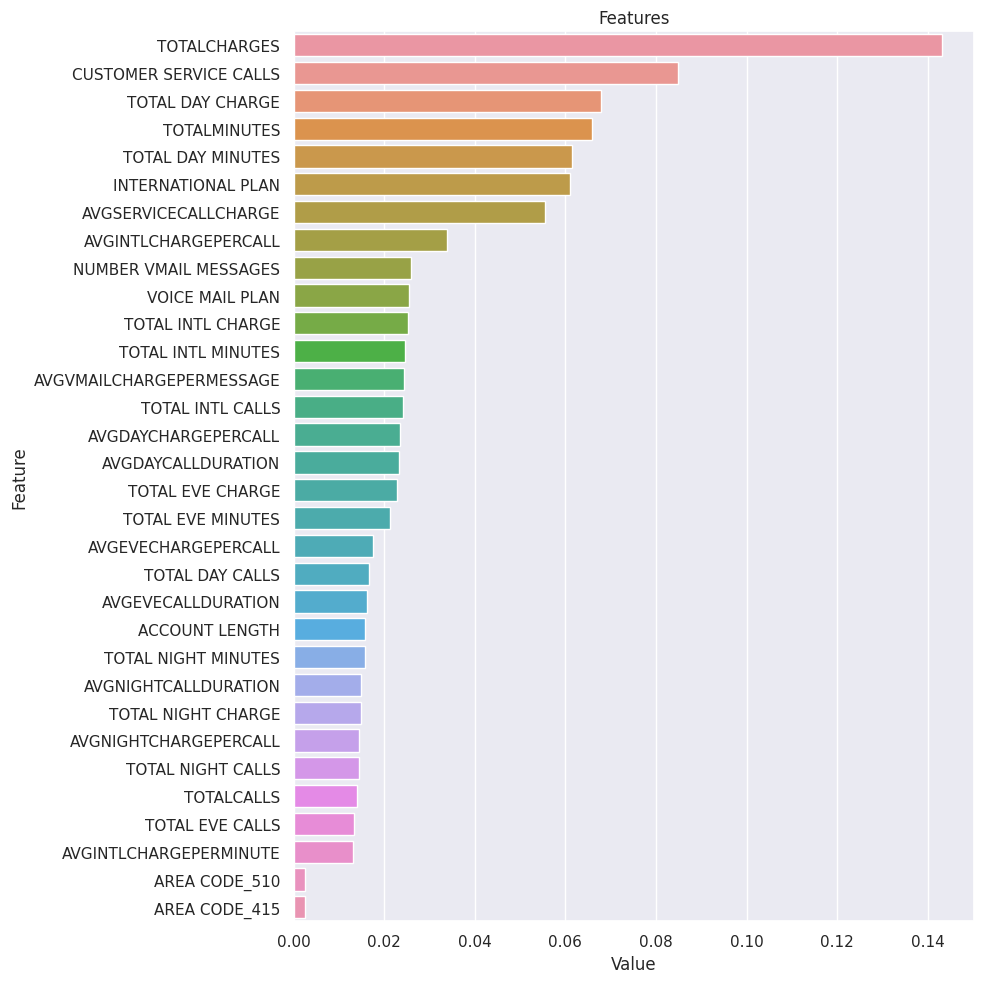

In [34]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

In [35]:
models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier(n_estimators=200)),
          ('SVC', SVC()),
          ('GBM', GradientBoostingClassifier(n_estimators=200, learning_rate=0.06)),
          ("XGBoost", XGBClassifier(learning_rate=0.06)),
          ("LightGBM", LGBMClassifier(learning_rate=0.06, verbose=-1)),
          ("CatBoost", CatBoostClassifier(learning_rate=0.06,verbose=False))]

In [36]:
acclist=[]
for name, model in models:
    acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy"))
    acclist.append([name,acc])
    print(f"ACC: {round(acc, 4)} ({name}) ")

ACC: 0.8667 (LR) 
ACC: 0.8903 (KNN) 
ACC: 0.9417 (CART) 
ACC: 0.9644 (RF) 
ACC: 0.9057 (SVC) 
ACC: 0.9721 (GBM) 
ACC: 0.9717 (XGBoost) 
ACC: 0.9726 (LightGBM) 
ACC: 0.9734 (CatBoost) 


In [37]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

lgbm_accuracy=round(accuracy_score(y_test,y_pred), 4)*100
lgbm_accuracy

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 327, number of negative: 2006
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5401
[LightGBM] [Info] Number of data points in the train set: 2333, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140163 -> initscore=-1.813938
[LightGBM] [Info] Start training from score -1.813938


95.0

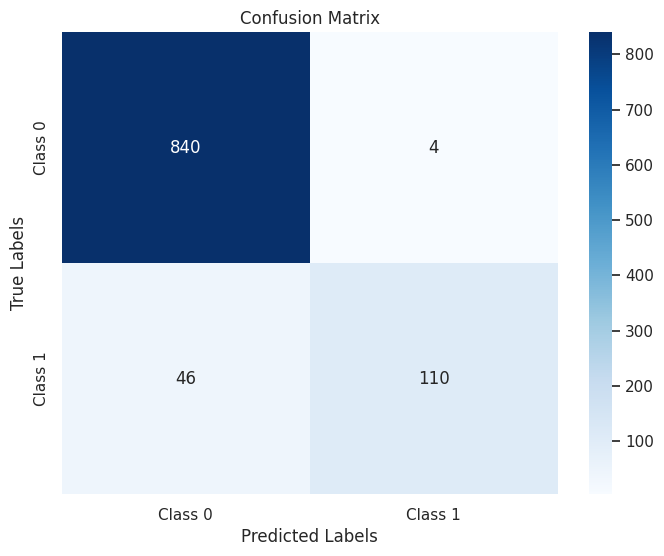

In [38]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['Class 0', 'Class 1']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [39]:
cat = CatBoostClassifier(learning_rate = 0.05, verbose =False)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)

cat_accuracy=round(accuracy_score(y_test,y_pred), 4)*100
cat_accuracy

95.0

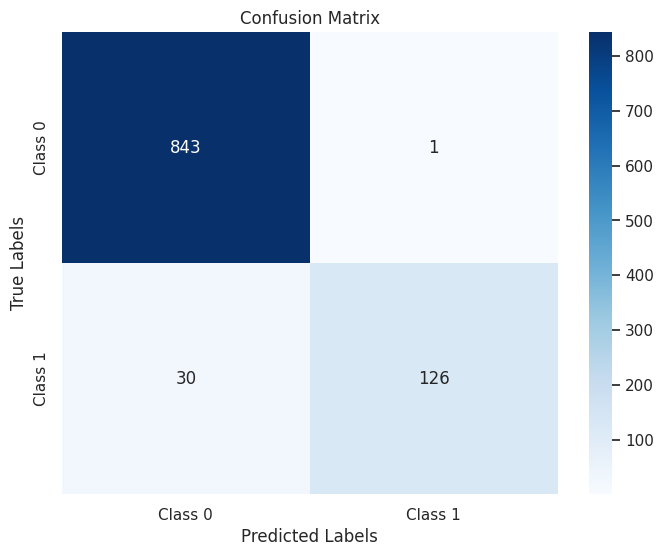

In [40]:
cm = confusion_matrix(y_test, y_pred_cat)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

2024-04-05 14:10:37.189007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 14:10:37.189105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 14:10:37.328970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [42]:
X_train.shape[1]

32

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(X_train.shape[1],), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(16, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(8, activation="elu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
50/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6326 - loss: 0.8331

I0000 00:00:1712326257.780985     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.6631 - loss: 0.8067 - val_accuracy: 0.8440 - val_loss: 0.5932
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8293 - loss: 0.6357 - val_accuracy: 0.8440 - val_loss: 0.5599
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8523 - loss: 0.5957 - val_accuracy: 0.8440 - val_loss: 0.5224
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8585 - loss: 0.5597 - val_accuracy: 0.8440 - val_loss: 0.5019
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8515 - loss: 0.5406 - val_accuracy: 0.8560 - val_loss: 0.4774
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8731 - loss: 0.4995 - val_accuracy: 0.8680 - val_loss: 0.4550
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8683 - loss: 0.4808 - val_accuracy: 0.8820 - val_loss: 0.4354
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8640 - loss: 0.4954 - val_accuracy: 0.8890 - val_loss: 

In [45]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9359 - loss: 0.2602 
[0.26371484994888306, 0.9309999942779541]
Loss =  0.26371484994888306
Accuracy =  0.9309999942779541


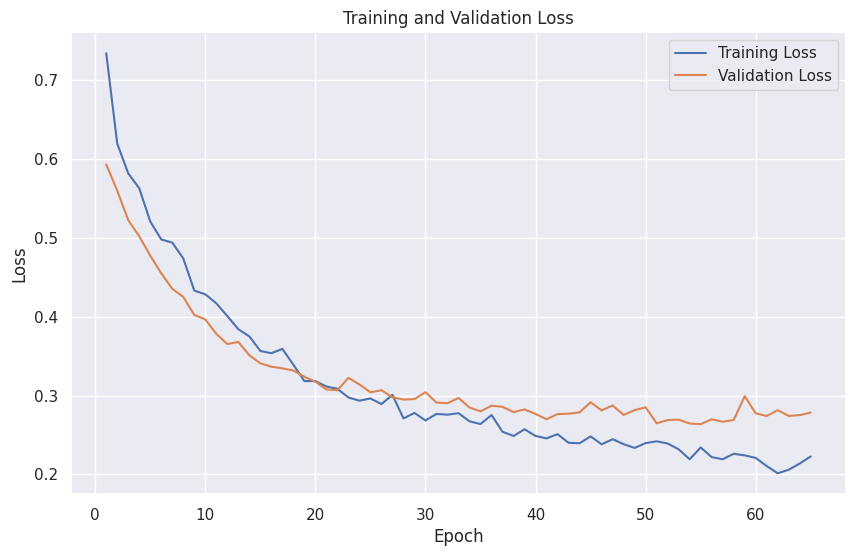

In [46]:
plt.figure(figsize=(10, 6))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [47]:
predicted = model.predict(X_test)
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [48]:
predicted

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

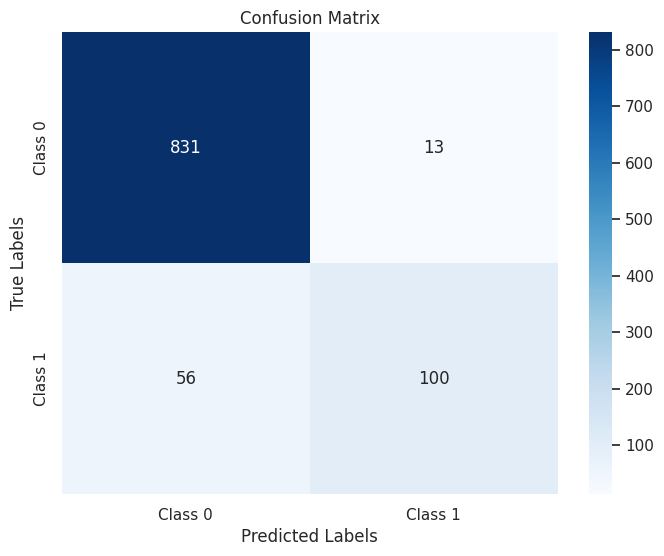

In [49]:
cm = confusion_matrix(y_test, predicted)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()